# IMDb Reviews Sentiment Analysis

In [1]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')

# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/Colab Notebooks/RNN/imdb/'

# Get the absolute path of the data
abspath_data = '/content/drive/My Drive/Colab Notebooks/RNN/imdb/imdb_data/'

Mounted at /content/drive


In [ ]:
%cd $abspath_data
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xvf  'aclImdb_v1.tar.gz';

In [ ]:
%cd /content/drive/My\ Drive/

/content/drive/My Drive


In [2]:
!pip install -q tensorflow_addons;
!pip install -q sentencepiece;
!pip install -q tf-models-official;
!pip install -q tensorflow-text;

     |████████████████████████████████| 706kB 13.7MB/s 
     |████████████████████████████████| 1.2MB 13.2MB/s 
     |████████████████████████████████| 1.1MB 13.8MB/s 
     |████████████████████████████████| 102kB 13.2MB/s 
     |████████████████████████████████| 37.6MB 122kB/s 
     |████████████████████████████████| 358kB 59.2MB/s 
     |████████████████████████████████| 645kB 39.3MB/s 
     |████████████████████████████████| 174kB 61.4MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 3.4MB 17.1MB/s 


In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib sizes and settings
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

# TensorFlow libraries
%tensorflow_version 2.x 
import numpy as np
import tensorflow_addons as tfa
import tensorflow as tf
import tensorflow_hub as hub
import keras
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   print(
#       '\n\nThis error most likely means that this notebook is not '
#       'configured to use a GPU.  Change this in Notebook Settings via the '
#       'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
#   raise SystemError('GPU device not found')

# Base libraries
import matplotlib.pyplot as plt
random_seed = 81
import numpy as np
import pandas as pd
from os import listdir
import string
from tqdm import tqdm
import pickle
import os

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# spaCy
import spacy
nlp = spacy.load('en_core_web_sm')

# Gensim
import gensim

tf.random.set_seed(random_seed)
np.random.seed(random_seed)

# 1. Data Pre-processing

In [4]:
# upload review .txt files into a dictionary
data_Dict = {"aclImdb/train/neg":[], "aclImdb/train/pos":[], "aclImdb/test/neg":[], "aclImdb/test/pos":[]}
for directory in list(data_Dict.keys()):
    for file in tqdm(os.listdir(abspath_data+directory)):
        data_Dict[directory].append(open(abspath_data+directory+'/'+file, encoding="utf8").read())

In [ ]:
Create a train_df dataframe
train_neg = pd.DataFrame({"review":data_Dict["aclImdb/train/neg"], "label":[0]*len(data_Dict["aclImdb/train/neg"])})
train_pos = pd.DataFrame({"review":data_Dict["aclImdb/train/pos"], "label":[1]*len(data_Dict["aclImdb/train/pos"])})
train_df = pd.concat([train_neg, train_pos])
# Shuffle data
train_df = train_df.sample(frac = 1).reset_index(drop=True)
train_df.head()

In [ ]:
# Create a test_df dataframe
test_neg = pd.DataFrame({"review":data_Dict["aclImdb/test/neg"], "label":[0]*len(data_Dict["aclImdb/test/neg"])})
test_pos = pd.DataFrame({"review":data_Dict["aclImdb/test/pos"], "label":[1]*len(data_Dict["aclImdb/test/pos"])})
test_df = pd.concat([test_neg, test_pos])
# Shuffle data
test_df = test_df.sample(frac = 1).reset_index(drop=True)
test_df.head()

In [ ]:
train_df.to_csv(abspath_data+'train_df.csv')
test_df.to_csv(abspath_data+'test_df.csv')

In [4]:
train_df = pd.read_csv(abspath_data+'train_df.csv')
test_df =  pd.read_csv(abspath_data+'test_df.csv')

In [6]:
def tokenizer_spacy(df, col, filename):
  # initialize list to be populated with the tokenized answers
  train_tokenized = []
  # Convert answers to a list
  train_list = df[col].values.tolist()
  # Loop through each answer
  for answer in tqdm(train_list):
      # empty string to populate with the chosen tokens
      tokens_joined = ''
      # spacy object pepares sentence to be parsed
      nlpd = nlp(answer)
      # for each word in answer
      for t in nlpd:
          # check that it is alphabetic, not a stopword, not punctuation and not a space
          if (t.is_alpha) and (not t.is_stop) and (not t.is_punct) and (not t.is_space):
              # if all conditions above are met, covert token back to string, normalize word to its Lemma, lower letter cases and add to empty string with a space behind it to keep words seperate
              tokens_joined += ' '+t.lemma_.lower()
      # append resulting string to the train_tokenized list
      train_tokenized.append(tokens_joined.strip())
  # save resulting file in pickle format
  pickle.dump(train_tokenized, open(abspath_data+filename+'.pkl', 'wb'))
  return train_tokenized

In [7]:
train_tokenized = tokenizer_spacy(train_df, 'review', 'train_tokenized')
test_tokenized = tokenizer_spacy(test_df, 'review', 'test_tokenized')

100%|██████████| 25000/25000 [16:09<00:00, 25.78it/s]


In [5]:
train_tokenized =pickle.load(open(abspath_data+"train_tokenized.pkl", 'rb'))
test_tokenized =pickle.load(open(abspath_data+"test_tokenized.pkl", 'rb'))

In [6]:
train_df['review'][0]

'I\'ll admit that I don\'t expect much from a Roger Corman film. Generally, I expect a lot of walking and bad scripts. Yet in this case, I am pleasantly surprised.<br /><br />The Gunslinger is a story of a woman (played by the spunky Beverly Garland) who takes over as sheriff after her husband is brutally murdered. Ms. Garland is a pretty good shot herself, killing one of the murderers the next day at her husband\'s funeral. Her first task is to shut down the local bar that is violating the town curfew. The bar\'s owner is trying to buy land in anticipation of being bought out by the (hoped-for) railroad. However, Ms. Garland is a thorn in her plans, and the bar matron hires a man to kill Ms. Garland.<br /><br />Because of Ms. Garland\'s plays her role honestly and realistically, there is absolutely no temptation to go to Suzanne Somers "She\'s the Sheriff" jokes. With the exception of a couple of faux pas (the apartment door that opens OUT from the inside, jeep tracks, and the two hor

In [7]:
train_tokenized[0]

'admit expect roger corman film generally expect lot walk bad script case pleasantly gunslinger story woman play spunky beverly garland take sheriff husband brutally murder garland pretty good shot kill murderer day husband funeral task shut local bar violate town curfew bar owner try buy land anticipation buy hope railroad garland thorn plan bar matron hire man kill garland play role honestly realistically absolutely temptation suzanne somers sheriff joke exception couple faux pas apartment door open inside jeep track horseman wait screen cue ride corner movie passable movie fare corman resist pad film horse riding scene like walk say gunslinger horse opera worth time'

In [ ]:
print(len(train_tokenized), len(test_tokenized))

25000 25000


In [8]:
y_train = np.asarray(train_df['label'].values.tolist(), dtype=np.int32)
y_test = np.asarray(test_df['label'].values.tolist(), dtype=np.int32)
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))
print(len(y_train), len(y_test))

(array([0, 1], dtype=int32), array([12500, 12500]))
(array([0, 1], dtype=int32), array([12500, 12500]))
25000 25000


# 2. Naive Bayes Classifier

First model is the Naive Bayes classifer. A classic method to classify text data. The tokenized reviews are vectorized using CountVectorizer and TfidfVectorizer then classified using sklearn's MultinomialNB. The hyper-parameters are varied using GridSearchCV to find their optimal values.

In [ ]:
vectorizers = {'counter': CountVectorizer(),
                'tfidf': TfidfVectorizer()}
pipes = {}

for acronym, vec in vectorizers.items():
    pipes[acronym] = Pipeline(steps=[('vec', vec), ('mnb', MultinomialNB(alpha=1))])

# param grid for CountVectorizer and TfIdf
ngram_range = [(1, 1), (2, 2)]
max_df=[0.8, 0.9, 1.0]
min_df=[1, 0.01, 0.02]
max_features= [5500, 10500, 50500, 100500, 150500, None]

param_grids = {}
# Update param_grids
param_grids['counter'] = [{'vec__ngram_range': ngram_range,
                           'vec__max_df': max_df,
                           'vec__min_df': min_df,
                           'vec__max_features': max_features}]

param_grids['tfidf'] = [{'vec__ngram_range': ngram_range,
                           'vec__max_df': max_df,
                           'vec__min_df': min_df,
                           'vec__max_features': max_features}]

In [ ]:
best_score_params_estimator_gs = []

for acronym in pipes.keys():
  gs = GridSearchCV(estimator=pipes[acronym],
                    param_grid=param_grids[acronym],
                    scoring='accuracy',
                    n_jobs=2,
                    cv = 5,
                    refit=True,
                    return_train_score=True,
                    verbose=0)
  gs = gs.fit(train_tokenized, y_train)
  best_score_params_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
  
  cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])
  important_columns = ['rank_test_score', 'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'mean_fit_time',
                      'std_fit_time', 'mean_score_time', 'std_score_time']

  cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

  cv_results.to_csv(path_or_buf=abspath_curr + 'GridSearchCV/' + acronym + '.csv', index=False)

best_score_params_estimator_gs = sorted(best_score_params_estimator_gs, key=lambda x : x[0], reverse=True)
gs_table = pd.DataFrame(best_score_params_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])

In [ ]:
cv_results.to_csv(path_or_buf=abspath_curr + 'GridSearchCV/' + acronym + '.csv', index=False)

In [ ]:
gs_table

,best_score,best_param,best_estimator
0,0.86104,"{'vec__max_df': 0.8, 'vec__max_features': 1005...","(TfidfVectorizer(analyzer='word', binary=False..."
1,0.85492,"{'vec__max_df': 0.8, 'vec__max_features': None...","(CountVectorizer(analyzer='word', binary=False..."


In [ ]:
gs_table['best_param'][0]

{'vec__max_df': 0.8,
 'vec__max_features': 100500,
 'vec__min_df': 1,
 'vec__ngram_range': (1, 1)}

In [ ]:
def print_scores(pred, label):
  print(f'Accuracy_score: {accuracy_score(label, pred):.2f}', 
        f'f1_score: {f1_score(label, pred):.2f}', 
        f'recall_score: {recall_score(label, pred):.2f}', 
        f'precision_score: {precision_score(label, pred):.2f}', sep='\n', end='\n\n')

In [ ]:
transform_test = gs_table['best_estimator'][0]['vec'].transform(test_tokenized)
pred = gs_table['best_estimator'][0]['mnb'].predict(transform_test)
print_scores(pred, y_test)

Accuracy_score: 0.82
f1_score: 0.82
recall_score: 0.78
precision_score: 0.86



# 3. RNN using LSTM cells

Prior to running the data through the RNN layers, the word tokens vector embeddings representations are extracted from Stanford's GloVe pretrained model to form the embeddings layer in the Neural Network's architecture.

In [11]:
# initialize a dictionary to store {word :[vector embedding representation of that word],...}
word_emb_w2v = {}
# impore the word vector pretrained model glove with size 300.
file_emb = open(abspath_data+"glove.6B.300d.txt", encoding="utf-8")
for emb in tqdm(file_emb):
  # its text file each line will look like:
  # the 0.04656 0.21318 -0.0074364 -0.45854 ... 
  array = emb.split()
  # split, make the first element (the) the key
  word = str(array[0])
  # make the rest of the elements as a float numpy list for the value
  vector = np.asarray(array[1:], dtype=np.float32)
  word_emb_w2v[word] = vector
file_emb.close()

400000it [00:28, 13882.99it/s]


In [12]:
lengths = [len(token_list.split(' ')) for token_list in train_tokenized+test_tokenized]
max_len = max(lengths)
print(max_len)

1285


Bag of words with the same length for each review is formed in the code below.

In [13]:
tf_tokenizer = tf.keras.preprocessing.text.Tokenizer()
tf_tokenizer.fit_on_texts(train_tokenized+test_tokenized)
word_index = tf_tokenizer.word_index

train_seq = tf_tokenizer.texts_to_sequences(train_tokenized)
test_seq = tf_tokenizer.texts_to_sequences(test_tokenized)
train_pad = tf.keras.preprocessing.sequence.pad_sequences(train_seq, maxlen=max_len)
test_pad = tf.keras.preprocessing.sequence.pad_sequences(test_seq, maxlen=max_len)

In [14]:
print(len(word_index))
print(train_pad.shape)
print(test_pad.shape)

86030
(25000, 1285)
(25000, 1285)


Here the bag of words are mapped with the their vector embedding representation.

In [15]:
num_o_words = len(word_index)+1
print(num_o_words)
emb_dim = 300 # size of w2v vector
emb_mtrx = np.zeros((num_o_words, emb_dim))

for word, i in word_index.items():
  if i > num_o_words:
    continue
  emb_vector = word_emb_w2v.get(word)
  if emb_vector is not None:
    emb_mtrx[i] = emb_vector

86031


## 3.1 First RNN, Single Bidirectional LSTM Layer

In [11]:
model_bi_lstm = tf.keras.Sequential()
emb_layer = tf.keras.layers.Embedding(input_dim= num_o_words,
                                      output_dim = emb_dim,
                                      embeddings_initializer = tf.keras.initializers.Constant(emb_mtrx),
                                      input_length= max_len,
                                      trainable=False)
model_bi_lstm.add(emb_layer)
model_bi_lstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model_bi_lstm.add(tf.keras.layers.Dense(64, activation='relu'))
model_bi_lstm.add(tf.keras.layers.Dense(1))
print(model_bi_lstm.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1285, 300)         25809300  
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               186880    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 26,004,501
Trainable params: 195,201
Non-trainable params: 25,809,300
_________________________________________________________________
None


In [12]:
directory = os.path.dirname(abspath_curr + 'results/model/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [9]:
# ModelCheckpoint callback
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=abspath_curr + 'results/model/model_bi_lstm.h5',
                                                      save_best_only=True,
                                                      save_weights_only=True)

# EarlyStopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)

# ReduceLROnPlateau callback
reduce_lr_on_plateau_cb = keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                                            patience=5)

In [14]:
model_bi_lstm.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      optimizer=tf.keras.optimizers.Adam(1e-4),
                      metrics='accuracy')

In [18]:
history = model_bi_lstm.fit(train_pad, y_train,
                            batch_size= 32,
                            epochs=16, 
                            validation_split = 0.2,
                            callbacks=[model_checkpoint_cb, early_stopping_cb, reduce_lr_on_plateau_cb])

Epoch 1/16
625/625 [==============================] - 396s 629ms/step - loss: 0.6122 - accuracy: 0.5812 - val_loss: 0.4186 - val_accuracy: 0.8136
Epoch 2/16
625/625 [==============================] - 399s 638ms/step - loss: 0.4124 - accuracy: 0.8071 - val_loss: 0.3978 - val_accuracy: 0.8314
Epoch 3/16
625/625 [==============================] - 399s 638ms/step - loss: 0.3818 - accuracy: 0.8246 - val_loss: 0.3700 - val_accuracy: 0.8326
Epoch 4/16
625/625 [==============================] - 394s 631ms/step - loss: 0.3588 - accuracy: 0.8351 - val_loss: 0.3635 - val_accuracy: 0.8288
Epoch 5/16
625/625 [==============================] - 399s 639ms/step - loss: 0.3438 - accuracy: 0.8468 - val_loss: 0.3537 - val_accuracy: 0.8380
Epoch 6/16
625/625 [==============================] - 401s 642ms/step - loss: 0.3308 - accuracy: 0.8537 - val_loss: 0.3483 - val_accuracy: 0.8426
Epoch 7/16
625/625 [==============================] - 402s 643ms/step - loss: 0.3265 - accuracy: 0.8519 - val_loss: 0.3522 -

In [19]:
# Make directory
directory = os.path.dirname(abspath_curr + 'results/figure/')
if not os.path.exists(directory):
    os.makedirs(directory)

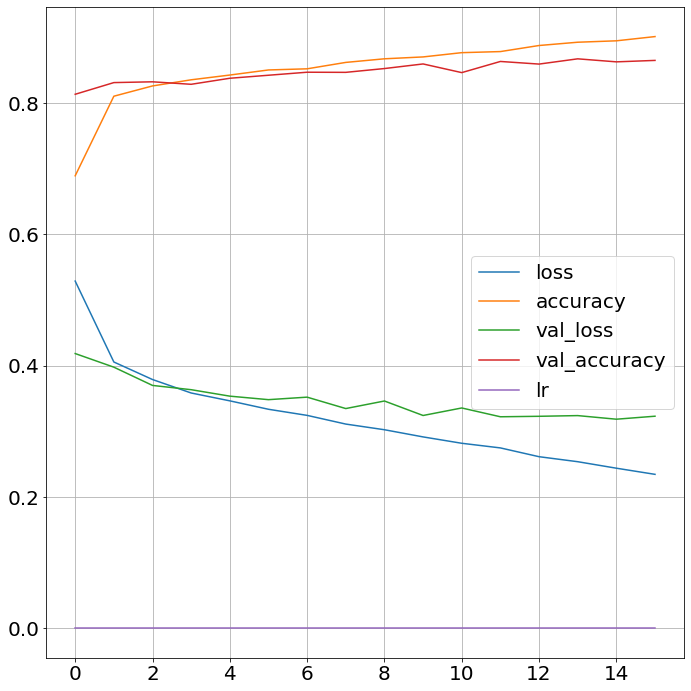

In [20]:
# Create a figure
plot_hist = pd.DataFrame(history.history)
plot_hist.plot(figsize=(10, 10))
plot_hist.to_csv(abspath_curr+'results/figure/plot_hist.csv')
# Set grid
plt.grid(True)

# Save and show the figure
plt.tight_layout()
plt.legend(loc='best')
plt.show()

In [21]:
# Load the saved model
model_bi_lstm.load_weights(abspath_curr + 'results/model/model_bi_lstm.h5')
loss, accuracy = model_bi_lstm.evaluate(x=test_pad, y=y_test)

782/782 [==============================] - 148s 190ms/step - loss: 0.3298 - accuracy: 0.8558


## 3.2 Second RNN, Multi Bidirectional LSTM Layers

In [16]:
model_bi_m_lstm = tf.keras.Sequential()
emb_layer = tf.keras.layers.Embedding(input_dim= num_o_words,
                                      output_dim = emb_dim,
                                      embeddings_initializer = tf.keras.initializers.Constant(emb_mtrx),
                                      input_length= max_len,
                                      trainable=False)
model_bi_m_lstm.add(emb_layer)
model_bi_m_lstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
model_bi_m_lstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
model_bi_m_lstm.add(tf.keras.layers.Dense(64, activation='relu'))
model_bi_m_lstm.add(tf.keras.layers.Dropout(0.5))
model_bi_m_lstm.add(tf.keras.layers.Dense(1))

print(model_bi_m_lstm.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1285, 300)         25809300  
_________________________________________________________________
bidirectional (Bidirectional (None, 1285, 128)         186880    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 26,041,621
Trainable params: 232,321
Non-trainable params: 25,809,300
____________________________________

In [17]:
# ModelCheckpoint callback
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=abspath_curr + 'results/model/model_bi_m_lstm.h5',
                                                      save_best_only=True,
                                                      save_weights_only=True)

In [18]:
model_bi_m_lstm.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                        optimizer=tf.keras.optimizers.Adam(1e-3),
                        metrics=['accuracy'])

In [19]:
history_1 = model_bi_m_lstm.fit(train_pad, y_train,
                              batch_size= 32,
                              epochs=6, 
                              validation_split = 0.2,
                              callbacks=[model_checkpoint_cb, early_stopping_cb, reduce_lr_on_plateau_cb])

Epoch 1/6
625/625 [==============================] - 140s 193ms/step - loss: 0.5303 - accuracy: 0.7105 - val_loss: 0.4081 - val_accuracy: 0.8258
Epoch 2/6
625/625 [==============================] - 120s 192ms/step - loss: 0.3757 - accuracy: 0.8325 - val_loss: 0.3508 - val_accuracy: 0.8524
Epoch 3/6
625/625 [==============================] - 120s 193ms/step - loss: 0.3261 - accuracy: 0.8565 - val_loss: 0.3559 - val_accuracy: 0.8554
Epoch 4/6
625/625 [==============================] - 121s 193ms/step - loss: 0.2896 - accuracy: 0.8757 - val_loss: 0.3173 - val_accuracy: 0.8614
Epoch 5/6
625/625 [==============================] - 121s 193ms/step - loss: 0.2513 - accuracy: 0.8963 - val_loss: 0.3200 - val_accuracy: 0.8638
Epoch 6/6
625/625 [==============================] - 121s 193ms/step - loss: 0.2153 - accuracy: 0.9143 - val_loss: 0.3405 - val_accuracy: 0.8624


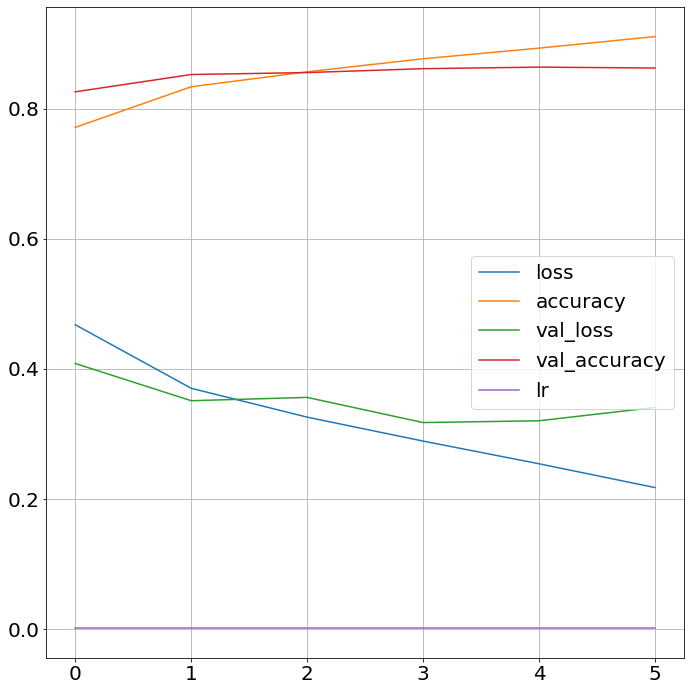

In [20]:
# Create a figure
plot_hist_1 = pd.DataFrame(history_1.history)
plot_hist_1.plot(figsize=(10, 10))
plot_hist_1.to_csv(abspath_curr+'results/figure/plot_hist_1.csv')
# Set grid
plt.grid(True)

# Save and show the figure
plt.tight_layout()
plt.legend(loc='best')
plt.show()

In [22]:
# Load the saved model
model_bi_m_lstm.load_weights(abspath_curr + 'results/model/model_bi_m_lstm.h5')
loss, accuracy = model_bi_m_lstm.evaluate(x=test_pad, y=y_test)

782/782 [==============================] - 67s 85ms/step - loss: 0.3197 - accuracy: 0.8580
